### 🌪️ Proyecto de Predicción de Magnitud de Tornados con LSTM
- Fuente: kaggle.com
- URL: https://www.kaggle.com/datasets/danbraswell/us-tornado-dataset-1950-2021
- Fecha: 30 de Abril del 2025

#### 🎯 Objetivo del Proyecto
Desarrollar un modelo de **Machine Learning** utilizando redes neuronales **LSTM** (*Long Short-Term Memory*) para predecir la magnitud de tornados en EE.UU.

#### 📁 Dataset Utilizado `us_tornado_dataset.csv`
**Contenido principal del dataset:**
- 📅 Fecha del evento
- 🗺️ Estado afectado (ubicación geográfica)
- 🏥 Número de heridos y fallecidos
- 📍 Coordenadas de inicio/fin (latitud, longitud)
- 📏 Longitud y ancho del tornado
- ⚡ Magnitud (Escala Fujita Mejorada - EF)

#### 🤖 Por qué LSTM?
| Característica | Beneficio para el Proyecto |
|---------------|---------------------------|
| 🕰️ Manejo de secuencias temporales | Ideal para analizar evolución histórica de tornados |
| 🧠 Memoria a largo plazo | Detecta patrones complejos en series de tiempo |
| 🌐 Capacidad espacial | Puede aprender de coordenadas geográficas |


### 0. Librerías

In [1]:
# 1. Librerías básicas y manejo de datos
import pickle
import logging
import pandas as pd
import numpy as np

# 2. Visualización de datos
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.graph_objects as go
import folium
from folium.plugins import MarkerCluster 

# 3. Preprocesamiento y feature engineering
from sklearn.preprocessing import (
    MinMaxScaler,
    LabelEncoder,
    OrdinalEncoder
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV

)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline

# 4. Modelos de Machine Learning
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier

# 5. Evaluación de modelos
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    matthews_corrcoef,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance

# 6. Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

2025-04-29 00:41:28.370716: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 00:41:28.584652: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 00:41:28.751231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745887289.039601     587 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745887289.128514     587 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745887289.768898     587 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### 1. Introducción

En este proyecto desarrollaremos un modelo de aprendizaje automático utilizando redes neuronales LSTM (Long Short-Term Memory) para predecir la magnitud de tornados en Estados Unidos, basándonos en un conjunto de datos históricos llamado us_tornado_dataset.csv. Este dataset incluye información relevante sobre cada evento de tornado, como la fecha, el estado afectado, número de heridos y fallecidos, coordenadas de inicio y fin, longitud y ancho del tornado.

El objetivo principal es construir un modelo capaz de aprender patrones temporales y espaciales a partir de estos datos, permitiendo realizar predicciones más precisas sobre la magnitud de futuros tornados. Las redes LSTM son especialmente útiles para este tipo de problemas, ya que están diseñadas para trabajar con secuencias de datos y capturar relaciones de largo plazo, lo que resulta ideal en contextos donde la evolución temporal de los eventos es relevante.

### 2. Conceptos (Marco teórico)

#### 🌪️ Tornados: Definición, Clasificación e Impacto

#### ❓ ¿Qué es un tornado?
**Un tornado** es una columna de aire que gira violentamente desde una tormenta eléctrica hasta la superficie terrestre.  

**Características principales:**  
- Forma de embudo característica  
- Vientos extremadamente fuertes  
- Causa daños severos en su trayectoria  
- Varía en intensidad, tamaño y duración  

**Formación:**  
Requiere condiciones atmosféricas específicas:  
✔ Humedad  
✔ Inestabilidad del aire  
✔ Cizalladura del viento  

---

#### 📊 Clasificación: Escala Fujita Mejorada (EF)
Sustituyó en 2007 a la Escala Fujita original (1971) por mayor precisión.

| Categoría | Velocidad Viento | Daños |
|-----------|------------------|-------|
| **EF0** | 65-85 mph (105-137 km/h) | Leves (ramas rotas) |
| **EF1** | 86-110 mph (138-177 km/h) | Moderados (tejados dañados) |
| **EF2** | 111-135 mph (178-217 km/h) | Considerables (árboles arrancados) |
| **EF3** | 136-165 mph (218-266 km/h) | Graves (paredes derrumbadas) |
| **EF4** | 166-200 mph (267-322 km/h) | Devastadores (casas destruidas) |
| **EF5** | >200 mph (322+ km/h) | Increíbles (estructuras niveladas) |

---

#### 💰 Impacto Económico
**Factores clave:**  
- **Categoría del tornado** (EF3+ = mayor destrucción)  
- **Ubicación** (zonas urbanas = mayor costo)  

**Áreas afectadas:**  
- 🏠 Viviendas e infraestructuras  
- 🌾 Agricultura (cosechas/ganado)  
- 🏢 Negocios (interrupciones operativas)  
- 🚑 Respuesta de emergencia  

#### 📌 Ejemplos destacados (EE.UU.)
| Evento | Año | Daños (USD) | Categoría |
|--------|-----|-------------|-----------|
| Joplin, MO | 2011 | $2.8 mil millones | EF5 |
| Moore, OK | 2013 | $2 mil millones | EF5 |
| **Promedio anual (1996-2023)** | - | **$1.1 mil millones** | EF3-EF4 |  


> **Dato crítico:** Un EF2 en zona urbana puede costar más que un EF4 en área rural.

#### Algoritmo LSTM (Long Short-Term Memory)

##### 📌 Definición
**LSTM** es un tipo especial de Red Neuronal Recurrente (RNN) diseñada para manejar dependencias de **largo plazo** en datos secuenciales, resolviendo el problema del *vanishing gradient* (desvanecimiento del gradiente) de las RNN tradicionales.

#### 🧠 Estructura Clave
#### 1. **Celda de Memoria**
   - Almacena información relevante por largos períodos.

#### 2. **Tres Puertas Reguladoras**
| Puerta             | Función                                                                 |
|--------------------|-------------------------------------------------------------------------|
| **Forget Gate**    | Decide qué información se descarta de la celda de memoria.              |
| **Input Gate**     | Actualiza la celda con nueva información importante.                   |
| **Output Gate**    | Controla qué información pasa al siguiente paso en la secuencia.       |

#### 🚀 Aplicaciones Comunes
- 📈 Predicción de series temporales (mercado bursátil, clima)
- 💬 Procesamiento de Lenguaje Natural (traducción, chatbots)
- 🎤 Reconocimiento de voz y video

#### ✅ Ventajas
✔ Maneja secuencias más largas que RNN estándar  
✔ Evita el desvanecimiento del gradiente  
✔ Captura patrones temporales complejos

#### ⚙️ Ejemplo en Keras
```python
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(10, 1)),  # Capa LSTM
    LSTM(units=32),
    Dense(1)  # Capa de salida
])
model.compile(optimizer='adam', loss='mse')

#### Diccionario de Datos


|Nombre|Descripción|Tipo|
|----|-----------|----|
|year|Año con 4 dígitos|Int|
|month|Mes (1-12)|Int|
|day|Día del mes|Int|
|date|Objeto datetime (ej. 2011-01-01)|Date|
|state|Estado donde se originó el tornado; abreviatura de 2 letras|String|
|magnitude|Escala Fujita mejorada para clasificar tornados|Int|
|injuries|Número de heridos durante el tornado|Int|
|fatalities|Número de fallecidos durante el tornado|Int|
|start_latitude|Latitud inicial en grados decimales|Float|
|start_longitude|Longitud inicial en grados decimales|Float|
|end_latitude|Latitud final en grados decimales|Float|
|end_longitude|Longitud final en grados decimales|Float|
|length|Longitud de la trayectoria en millas|Float|
|width|Ancho en yardas|Float|

### 3. Hipótesis

En este proyecto desarrollaremos un modelo de aprendizaje automático utilizando redes neuronales LSTM (Long Short-Term Memory) para predecir la magnitud de tornados en Estados Unidos, basándonos en un conjunto de datos históricos llamado us_tornado_dataset.csv. Este dataset incluye información relevante sobre cada evento de tornado, como la fecha, el estado afectado, número de heridos y fallecidos, coordenadas de inicio y fin, longitud y ancho del tornado.

El objetivo principal es construir un modelo capaz de aprender patrones temporales y espaciales a partir de estos datos, permitiendo realizar predicciones más precisas sobre la magnitud de futuros tornados. Las redes LSTM son especialmente útiles para este tipo de problemas, ya que están diseñadas para trabajar con secuencias de datos y capturar relaciones de largo plazo, lo que resulta ideal en contextos donde la evolución temporal de los eventos es relevante.

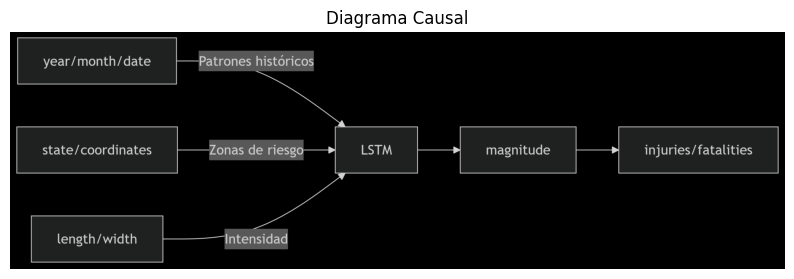

In [3]:
diag_causal = mpimg.imread('../diagrama_causal.png') 

# Mostrar imagen
plt.figure(figsize=(10, 6))  
plt.imshow(diag_causal)
plt.axis('off') 
plt.title('Diagrama Causal')
plt.show()

### 4. Preprocesamiento

In [2]:
df_raw = pd.read_csv('../data/raw/us_tornado_dataset_1950_2021.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67558 entries, 0 to 67557
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yr      67558 non-null  int64  
 1   mo      67558 non-null  int64  
 2   dy      67558 non-null  int64  
 3   date    67558 non-null  object 
 4   st      67558 non-null  object 
 5   mag     67558 non-null  int64  
 6   inj     67558 non-null  int64  
 7   fat     67558 non-null  int64  
 8   slat    67558 non-null  float64
 9   slon    67558 non-null  float64
 10  elat    67558 non-null  float64
 11  elon    67558 non-null  float64
 12  len     67558 non-null  float64
 13  wid     67558 non-null  int64  
dtypes: float64(5), int64(7), object(2)
memory usage: 7.2+ MB


In [3]:
df_raw.sample(10, random_state=2025)

,yr,mo,dy,date,st,mag,inj,fat,slat,slon,elat,elon,len,wid
44528,2003,6,4,2003-06-04,NM,0,0,0,36.65,-104.13,36.65,-104.13,0.50,100
25316,1985,8,31,1985-08-31,FL,1,0,0,28.25,-82.72,0.00,0.00,0.50,10
31651,1992,8,29,1992-08-29,FL,0,0,0,26.68,-80.05,0.00,0.00,0.10,10
23045,1983,4,23,1983-04-23,WA,0,0,0,46.90,-119.07,0.00,0.00,0.50,33
47201,2005,5,11,2005-05-11,IL,0,0,0,40.00,-91.17,40.00,-91.17,0.20,50
51002,2008,5,5,2008-05-05,TX,0,0,0,31.28,-102.65,31.31,-102.63,2.28,50
17846,1977,4,19,1977-04-19,TX,0,0,0,33.85,-98.83,0.00,0.00,0.10,10
50080,2007,6,29,2007-06-29,CO,0,0,0,38.04,-105.47,38.03,-105.47,1.00,75
24505,1984,7,5,1984-07-05,MA,1,0,0,42.50,-72.33,0.00,0.00,2.00,80
26125,1986,10,1,1986-10-01,WV,3,1,0,39.30,-80.78,0.00,0.00,1.00,200


In [3]:
df_baking = df_raw.copy()
df_baking = df_baking[df_baking['date'] > "2007-01-31"] #Tomamos la data de Febrero 2007 en adelante
df_baking = df_baking[(df_baking['mag'] != -9) & (df_baking['mag'] != 5) & (df_baking['mag'] !=4)] #Eliminamos filas sin magnitud y magnitud 4 y 5
df_baking = df_baking[(df_baking['st'] != 'VI') & (df_baking['st'] != 'DC')] #Eliminamos outliers de Estado
df_baking = df_baking[(df_baking['len'] != 0) & (df_baking['wid'] != 0) & (df_baking["elat"] != 0)] ##Eliminamos filas sin trayecto o ancho conocidos
df_baking.drop_duplicates(inplace=True) #Eliminamos filas duplicadas
df_baking['date'] = pd.to_datetime(df_baking['date']) #Convertimos columna date en tipo Date
df_baking = df_baking.sort_values('date') #Ordenamos por orden cronologico
df_baking.reset_index(drop=True, inplace=True) #Reinciamos Indices 
df_baking.rename(columns={"yr": "year", "mo": "month", "dy": "day", "date": "date", "st": "state", "mag": "magnitude",
                          "inj": "injuries", "fat": "fatalities", "slat": "start_latitude", "slon": "start_longitude",
                          "elat": "end_latitude", "elon": "end_longitude","len": "length", "wid": "width"}, inplace=True)

#CREATING NEW COLUMN FOR US REGION
ne = ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA']
s = ['DE', 'MD', 'VA', 'WV', 'NC', 'SC', 'GA', 'FL', 'KY', 'TN', 'AL', 'MS', 'LA', 'TX','DC']
mw = ['IL', 'IN', 'IA', 'KS', 'MI', 'MN', 'MO', 'NE', 'ND', 'OH', 'SD', 'WI']
w = ['AZ', 'CA', 'CO', 'ID', 'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY']

regions = []


for state in df_baking['state']:
    if state in ne:
        region = 'e'
    elif state in s:
        region = 's'
    elif state in mw:
        region = 'mw'
    elif state in w:
        region = 'w'
    else:
        region = 'Unknown'  # For states not in any region

    regions.append(region)

df_baking['region'] = regions

df_baking['magnitude'] = df_baking['magnitude'].astype('category')
df_baking['state'] = df_baking['state'].astype('category')
df_baking['region'] = df_baking['region'].astype('category')
df_baking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17248 entries, 0 to 17247
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   year             17248 non-null  int64         
 1   month            17248 non-null  int64         
 2   day              17248 non-null  int64         
 3   date             17248 non-null  datetime64[ns]
 4   state            17248 non-null  category      
 5   magnitude        17248 non-null  category      
 6   injuries         17248 non-null  int64         
 7   fatalities       17248 non-null  int64         
 8   start_latitude   17248 non-null  float64       
 9   start_longitude  17248 non-null  float64       
 10  end_latitude     17248 non-null  float64       
 11  end_longitude    17248 non-null  float64       
 12  length           17248 non-null  float64       
 13  width            17248 non-null  int64         
 14  region           17248 non-null  categ

In [8]:
df = df_baking.copy()

### 5. Análisis Exploratorio de Datos

In [9]:
df_train = df.iloc[:14741,:] # 85% del dataset para df_train
df_val = df.iloc[14741:15994,:] # 7.5% del dataset para df_val
df_test = df.iloc[15994:,:] # 7.5% del dataset para df_test

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.shape, df_val.shape, df_test.shape

((14741, 15), (1253, 15), (1254, 15))

<Axes: title={'center': 'Frcuencia de Tornados por Mes'}, xlabel='month'>

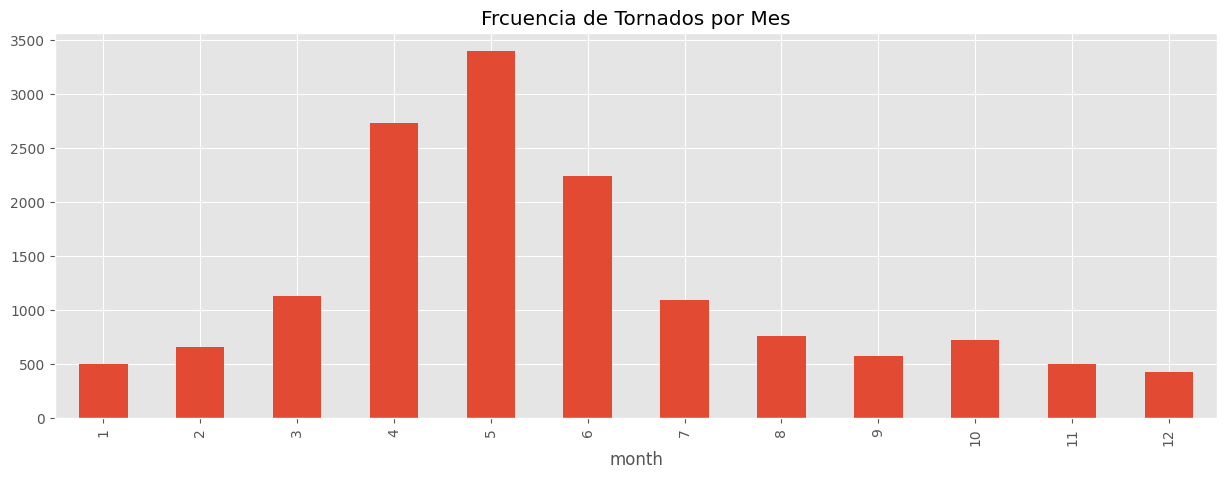

In [147]:
plt.style.use('ggplot');
plt.title('Frcuencia de Tornados por Mes')
df_train['month'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))

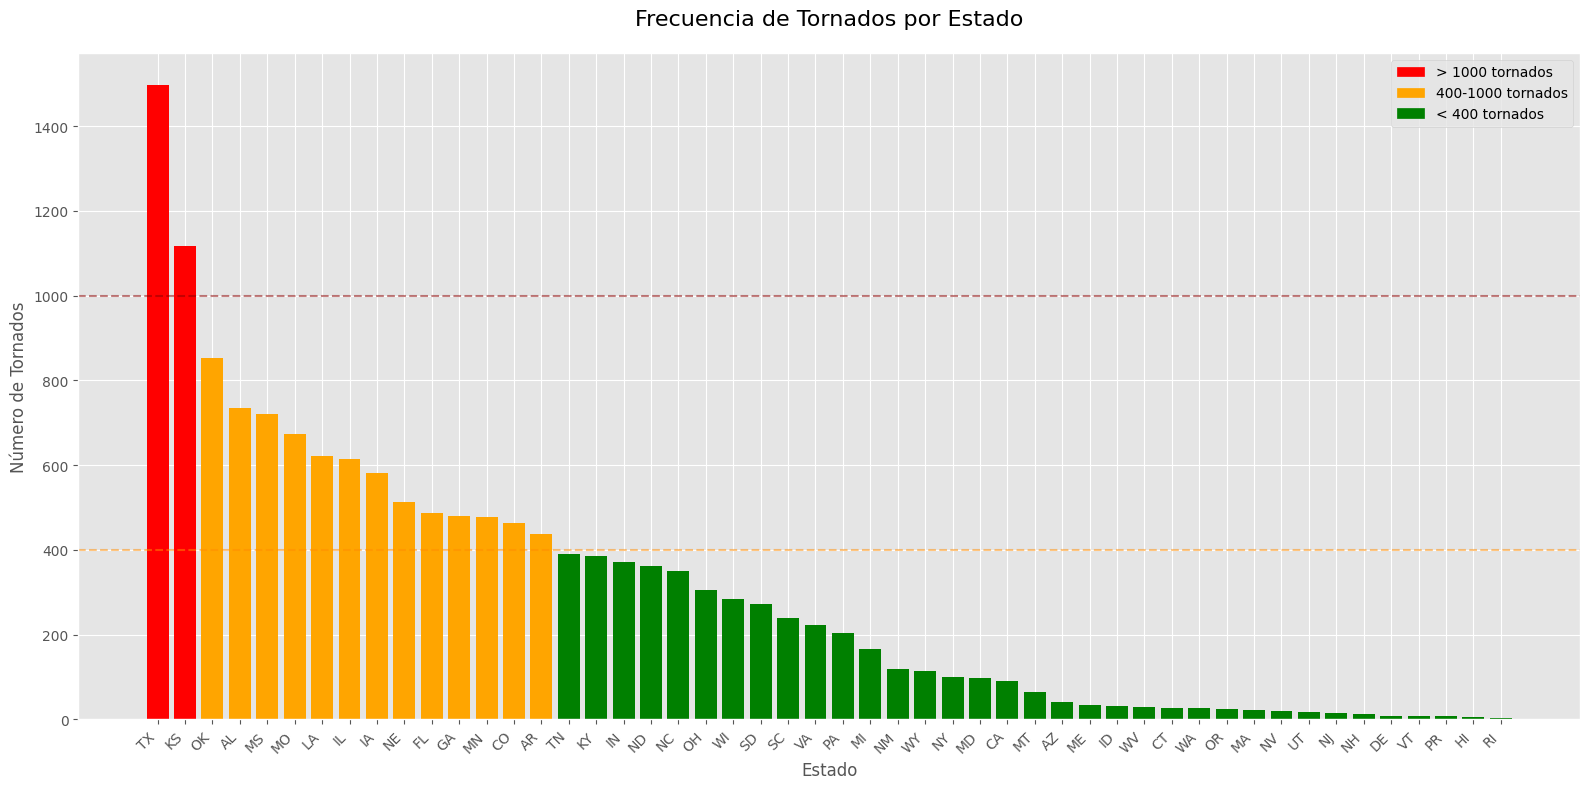

In [148]:
state_counts = df_train['state'].value_counts().sort_values(ascending=False)

colors = []
for count in state_counts:
    if count > 1000:
        colors.append('red')
    elif 400 <= count <= 1000:
        colors.append('orange')
    else:
        colors.append('green')

plt.figure(figsize=(16, 8))
bars = plt.bar(state_counts.index, state_counts.values, color=colors)

plt.title('Frecuencia de Tornados por Estado', fontsize=16, pad=20)
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Número de Tornados', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.axhline(y=1000, color='darkred', linestyle='--', alpha=0.5)
plt.axhline(y=400, color='darkorange', linestyle='--', alpha=0.5)

legend_elements = [
    mpatches.Patch(color='red', label='> 1000 tornados'),
    mpatches.Patch(color='orange', label='400-1000 tornados'),
    mpatches.Patch(color='green', label='< 400 tornados')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

In [149]:
# Filtrar por año
year_filter  = 2019
df_filtered = df_train[df_train['year'] == year_filter].copy()  # Cambia el año según necesites

# Mapa
map = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Agrupamiento de marcadores
marker_cluster = MarkerCluster().add_to(map)

# Añadir elementos en lotes o grupos
for coords in df_filtered[['start_latitude', 'start_longitude']].values:
    folium.CircleMarker(
        location=coords,
        radius=3,
        color='green',
        fill=True
    ).add_to(marker_cluster)

for coords in df_filtered[['end_latitude', 'end_longitude']].values:
    folium.CircleMarker(
        location=coords,
        radius=3,
        color='red',
        fill=True
    ).add_to(marker_cluster)

#Líneas de trayectoria
for _, row in df_filtered.iterrows():
    folium.PolyLine(
        locations=[(row['start_latitude'], row['start_longitude']), 
                  (row['end_latitude'], row['end_longitude'])],
        color='blue',
        weight=1
    ).add_to(map)

map

### 6. Desarrollo del modelo de machine learning - LSTM

In [150]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14741 entries, 0 to 14740
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   year             14741 non-null  int64         
 1   month            14741 non-null  int64         
 2   day              14741 non-null  int64         
 3   date             14741 non-null  datetime64[ns]
 4   state            14741 non-null  category      
 5   magnitude        14741 non-null  category      
 6   injuries         14741 non-null  int64         
 7   fatalities       14741 non-null  int64         
 8   start_latitude   14741 non-null  float64       
 9   start_longitude  14741 non-null  float64       
 10  end_latitude     14741 non-null  float64       
 11  end_longitude    14741 non-null  float64       
 12  length           14741 non-null  float64       
 13  width            14741 non-null  int64         
 14  region           14741 non-null  categ

In [49]:
# Codificar 'magnitude' usando LabelEncoder
label_encoder = LabelEncoder()

df_train.loc[:, 'magnitude_encoded'] = label_encoder.fit_transform(df_train['magnitude'])
df_val.loc[:, 'magnitude_encoded'] = label_encoder.transform(df_val['magnitude'])
df_test.loc[:, 'magnitude_encoded'] = label_encoder.transform(df_test['magnitude'])

# Codificar 'month' usando OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

df_train.loc[:, 'month_encoded'] = ordinal_encoder.fit_transform(df_train[['month']])
df_val.loc[:, 'month_encoded'] = ordinal_encoder.transform(df_val[['month']])
df_test.loc[:, 'month_encoded'] = ordinal_encoder.transform(df_test[['month']])

# Verifica que las columnas se hayan agregado correctamente
print(df_train[['magnitude', 'magnitude_encoded', 'month', 'month_encoded']].head())

# Características a escalar (sin la columna 'month' original)
features = ['month_encoded', 'start_latitude', 'start_longitude']

# Escalamos las características
scaler = MinMaxScaler()

# Escalar los datos (fit en el set de entrenamiento y transformar en el de validación y test)
train_scaled = scaler.fit_transform(df_train[features])  # solo fit en el set de entrenamiento
val_scaled = scaler.transform(df_val[features])
test_scaled = scaler.transform(df_test[features])

   magnitude  magnitude_encoded  month  month_encoded
0          0                  0    1.0            1.0
1          1                  1    1.0            1.0
2          3                  3    1.0            1.0
3          3                  3    1.0            1.0
4          1                  1    1.0            1.0


In [50]:
def secuencias(dataset, n_steps):
    X = []
    for i in range(len(dataset) - n_steps):
        X.append(dataset[i:i+n_steps, :])  
    return np.array(X)

In [58]:
# Crear las secuencias (X, y) para entrenamiento, validación y test
n_steps = 20  # Número de filas  para las secuencias
X_train = secuencias(train_scaled, n_steps)
X_val = secuencias(val_scaled, n_steps)
X_test = secuencias(test_scaled, n_steps)

# Asignar las etiquetas (magnitude_encoded) como target
y_train = df_train['magnitude_encoded'].values[n_steps:]
y_val = df_val['magnitude_encoded'].values[n_steps:]
y_test = df_test['magnitude_encoded'].values[n_steps:]

In [59]:
# Calcular los pesos para las clases de y_train
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(y_train), 
                                     y=y_train)

# Convertir a diccionario para usarlo en el modelo
class_weight_dict = dict(enumerate(class_weights))
print("Pesos de clase:", class_weight_dict)

Pesos de clase: {0: np.float64(0.45579078455790784), 1: np.float64(0.7390953150242326), 2: np.float64(2.7853881278538815), 3: np.float64(10.63953488372093)}


In [60]:
# Crear el modelo
lstm_tornado = Sequential()

# Capa de entrada: (n_steps, 3 features)
lstm_tornado.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # (20, 3)

# Capa LSTM
lstm_tornado.add(LSTM(units=100, return_sequences=False))

# Capa Dropout para evitar sobreajuste
lstm_tornado.add(Dropout(0.2))

# Número de clases (magnitudes únicas)
n_classes = len(np.unique(y_train))

# Capa de salida: clasificación multiclase
lstm_tornado.add(Dense(n_classes, activation='softmax'))  # Softmax para clasificación

# Resumen del modelo
lstm_tornado.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 100)            │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,004 (164.08 KB)

 Trainable params: 42,004 (164.08 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Compilar el modelo
lstm_tornado.compile(optimizer='adam', 
                     loss='sparse_categorical_crossentropy',  # Correcto para y en formato entero
                     metrics=['accuracy'])


In [62]:
# EarlyStopping para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
y_hat_lstm = lstm_tornado.fit(X_train, y_train, 
                           epochs=50, 
                           batch_size=32, 
                           validation_data=(X_val, y_val), 
                           callbacks=[early_stop],
                           class_weight=class_weight_dict)


Epoch 1/50


458/458 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.2628 - loss: 1.4045 - val_accuracy: 0.4737 - val_loss: 1.3188
Epoch 2/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3888 - loss: 1.3794 - val_accuracy: 0.1948 - val_loss: 1.3619
Epoch 3/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3660 - loss: 1.3820 - val_accuracy: 0.3260 - val_loss: 1.3955
Epoch 4/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3198 - loss: 1.3807 - val_accuracy: 0.3496 - val_loss: 1.3554
Epoch 5/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3614 - loss: 1.3717 - val_accuracy: 0.3810 - val_loss: 1.3693
Epoch 6/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3975 - loss: 1.3026 - val_accuracy: 0.3064 - val_loss: 1.4061
Epoch 7/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3231 - loss: 1.3709 - val_accuracy: 0.3629 - val_loss: 1.2845
Epoch 8/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3101 - loss: 1.3979 - val_accuracy: 0.3166 - va

In [63]:
# Evaluar el modelo en el conjunto de test
test_loss, test_acc = lstm_tornado.evaluate(X_test, y_test)

# Imprimir la pérdida y precisión en el conjunto de test
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")


15/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4826 - loss: 1.1314 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4476 - loss: 1.2070
Test loss: 1.2266253232955933
Test accuracy: 0.4556862711906433


In [64]:
# Predicciones sobre el conjunto de test
y_hat_lstm = lstm_tornado.predict(X_test)
y_hat_class = np.argmax(y_hat_lstm, axis=1)  # Para obtener las clases predichas

# Imprimir el reporte de clasificación
print("Modelo LSTM")
print(classification_report(y_test, y_hat_class))

 1/40 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Modelo LSTM
              precision    recall  f1-score   support

           0       0.59      0.68      0.64       656
           1       0.47      0.26      0.33       486
           2       0.00      0.00      0.00       112
           3       0.03      0.38      0.06        21

    accuracy                           0.46      1275
   macro avg       0.27      0.33      0.26      1275
weighted avg       0.48      0.46      0.45      1275



In [65]:
# Restaurar 'magnitude'
df_train['magnitude'] = label_encoder.inverse_transform(df_train['magnitude_encoded'])
df_val['magnitude'] = label_encoder.inverse_transform(df_val['magnitude_encoded'])
df_test['magnitude'] = label_encoder.inverse_transform(df_test['magnitude_encoded'])

# Restaurar 'month'
df_train['month'] = ordinal_encoder.inverse_transform(df_train[['month_encoded']])
df_val['month'] = ordinal_encoder.inverse_transform(df_val[['month_encoded']])
df_test['month'] = ordinal_encoder.inverse_transform(df_test[['month_encoded']])


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


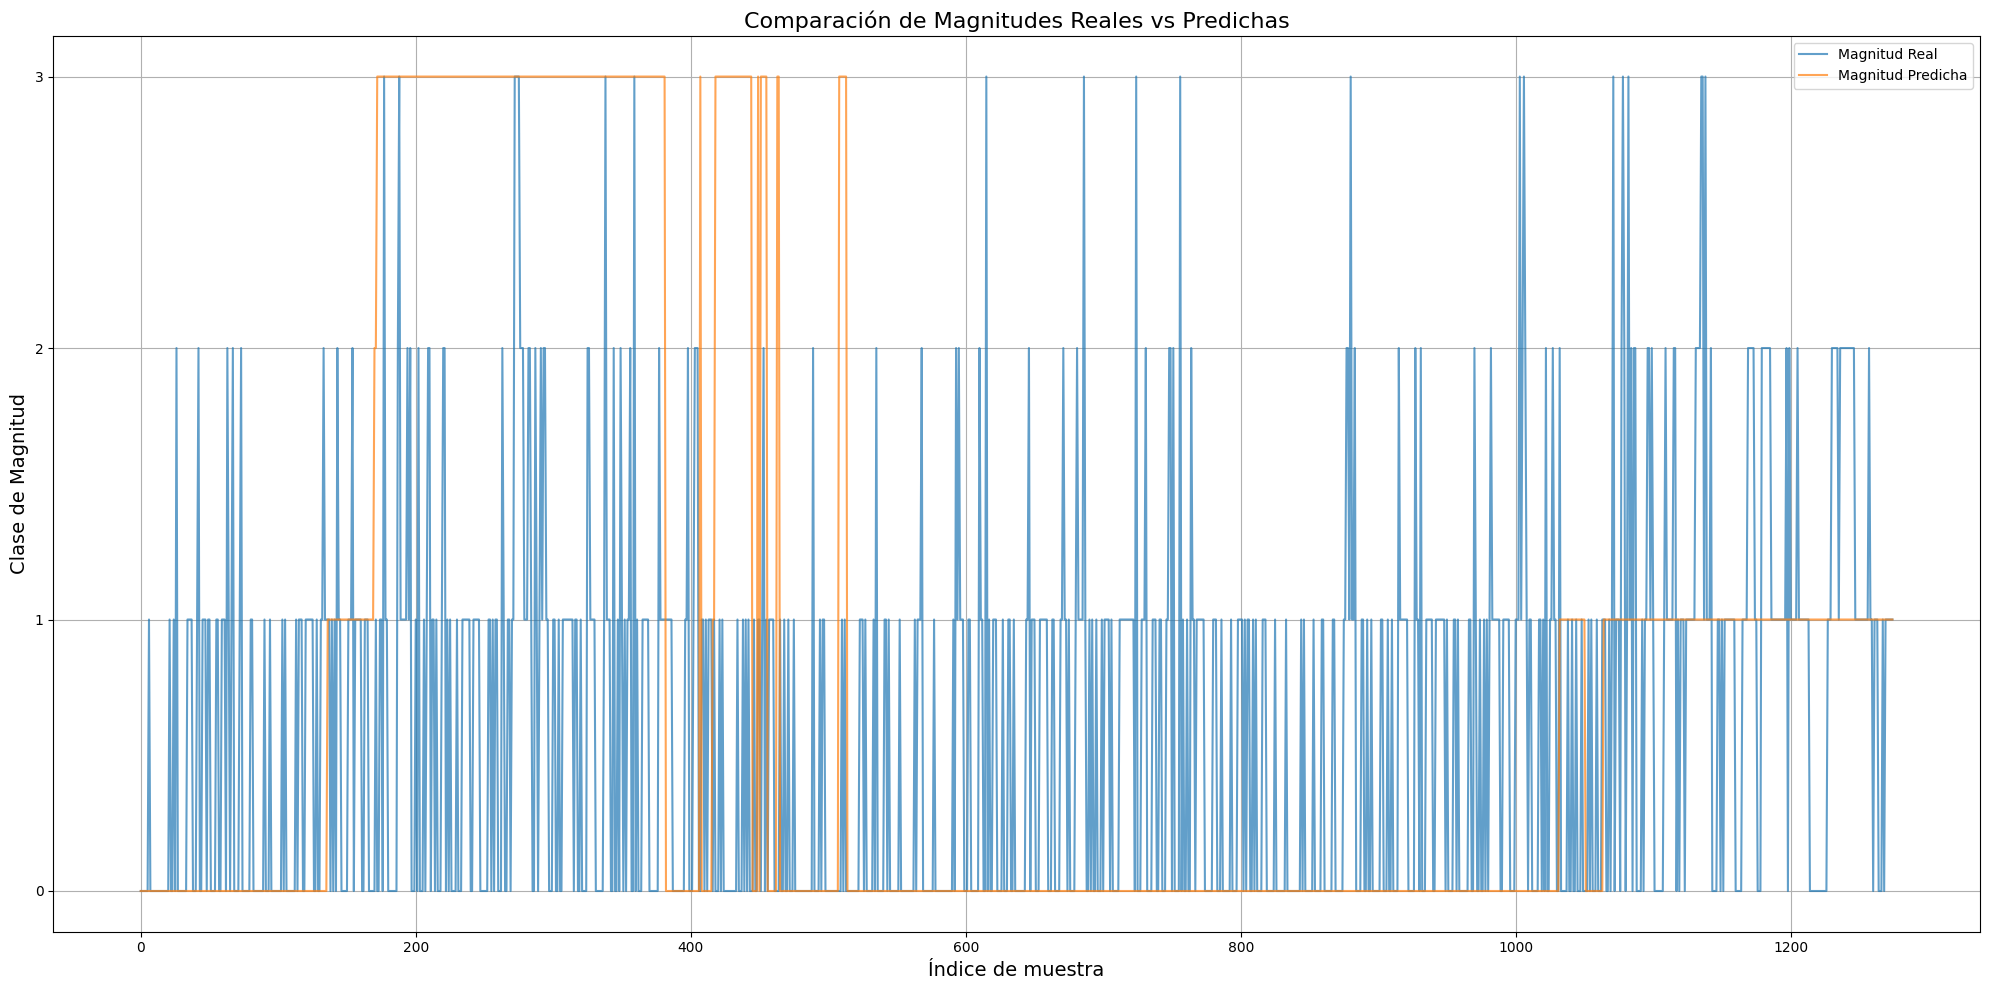

In [70]:
# Predicciones sobre el conjunto de test
predicciones = lstm_tornado.predict(X_test)

# Convertir predicciones probabilísticas a clases
y_hat_classes = np.argmax(predicciones, axis=1)

# Crear el gráfico
plt.figure(figsize=(20, 10))
plt.plot(y_test, label='Magnitud Real', alpha=0.7)
plt.plot(y_hat_classes, label='Magnitud Predicha', alpha=0.7)
plt.title('Comparación de Magnitudes Reales vs Predichas', fontsize=16)
plt.xlabel('Índice de muestra', fontsize=14)
plt.ylabel('Clase de Magnitud', fontsize=14)

# Escala en el eje Y en pasos de 1
plt.yticks(np.arange(min(y_test.min(), y_hat_classes.min()), 
                     max(y_test.max(), y_hat_classes.max()) + 1, 
                     1))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
with open("lstm_tornado.pkl", "wb") as file:
    pickle.dump(lstm_tornado, file)

### 7. Comparacion de modelos

#### Gradient Boosting

In [25]:
df = df_baking.copy()

In [26]:
train_size = int(0.85 * len(df))
val_size = int(0.075 * len(df))
test_size = len(df) - train_size - val_size

df_train = df.iloc[:train_size].reset_index(drop=True)
df_val = df.iloc[train_size:train_size + val_size].reset_index(drop=True)
df_test = df.iloc[train_size + val_size:].reset_index(drop=True)

print(df_train.shape, df_val.shape, df_test.shape)

(14660, 15) (1293, 15) (1295, 15)


In [27]:
# Separar columnas categóricas y numéricas
categorical_cols = ['month', 'state']
numeric_cols = ['start_latitude', 'start_longitude']

# Aplicar OrdinalEncoder solo a las columnas categóricas
ordinal_encoder = OrdinalEncoder()

df_train[categorical_cols] = ordinal_encoder.fit_transform(df_train[categorical_cols])
df_val[categorical_cols] = ordinal_encoder.transform(df_val[categorical_cols])
df_test[categorical_cols] = ordinal_encoder.transform(df_test[categorical_cols])

features = categorical_cols + numeric_cols
target = 'magnitude'

# Codificar el target
label_encoder = LabelEncoder()
df_train[target] = label_encoder.fit_transform(df_train[target])
df_val[target] = label_encoder.transform(df_val[target])
df_test[target] = label_encoder.transform(df_test[target])


In [28]:
X_train_gb = df_train[features]
y_train_gb = df_train[target]

X_val_gb = df_val[features]
y_val_gb = df_val[target]

X_test_gb = df_test[features]
y_test_gb = df_test[target]

In [29]:
# Crear el modelo con class_weight balanceado
gb_model = HistGradientBoostingClassifier(class_weight='balanced', max_iter=100)

gb_model.fit(X_train_gb, y_train_gb)


HistGradientBoostingClassifier(class_weight='balanced')

In [31]:
# Evaluar en validación
y_hat_val_gb = gb_model.predict(X_val_gb)

# Reporte
print("Reporte de Validación:")
print(classification_report(y_val_gb, y_hat_val_gb))

Reporte de Validación:
              precision    recall  f1-score   support

           0       0.64      0.54      0.59       631
           1       0.51      0.37      0.43       524
           2       0.14      0.24      0.18       112
           3       0.03      0.23      0.06        26

    accuracy                           0.44      1293
   macro avg       0.33      0.35      0.31      1293
weighted avg       0.53      0.44      0.48      1293



In [32]:
# Predicción sobre el conjunto de test
y_hat_test = gb_model.predict(X_test_gb)

# Reporte de clasificación
print("Reporte de Test:")
print(classification_report(y_test_gb, y_hat_test))

Reporte de Test:
              precision    recall  f1-score   support

           0       0.61      0.51      0.55       667
           1       0.41      0.32      0.36       494
           2       0.11      0.19      0.14       113
           3       0.05      0.38      0.09        21

    accuracy                           0.41      1295
   macro avg       0.30      0.35      0.29      1295
weighted avg       0.48      0.41      0.44      1295



#### Random Forest

In [33]:
X_train_rf = df_train[['month', 'state']].copy()
y_train_rf = df_train['magnitude'].copy()
X_test_rf = df_test[['month', 'state']].copy()
y_test_rf = df_test['magnitude'].copy()

In [34]:
label_encoder_rf = LabelEncoder()
y_train_enc_rf = label_encoder_rf.fit_transform(y_train_rf)
y_test_enc_rf = label_encoder_rf.transform(y_test_rf)

In [ ]:
# ADD PIPELINE / One Hot Encoder

In [35]:
clf_rf = RandomForestClassifier(
    class_weight='balanced',
    max_depth=30,
    n_estimators=100,
    random_state=42
)
clf_rf.fit(X_train_rf, y_train_enc_rf)


RandomForestClassifier(class_weight='balanced', max_depth=30, random_state=42)

In [36]:
y_hat_rf =  clf_rf.predict(X_test_rf)
print(f'accuracy: {accuracy_score(y_test_enc_rf,y_hat_rf)*100:.1f}')
print(f'f1 score (macro): {f1_score(y_test_enc_rf, y_hat_rf, average="macro") * 100:.1f}')

accuracy: 38.4
f1 score (macro): 26.0


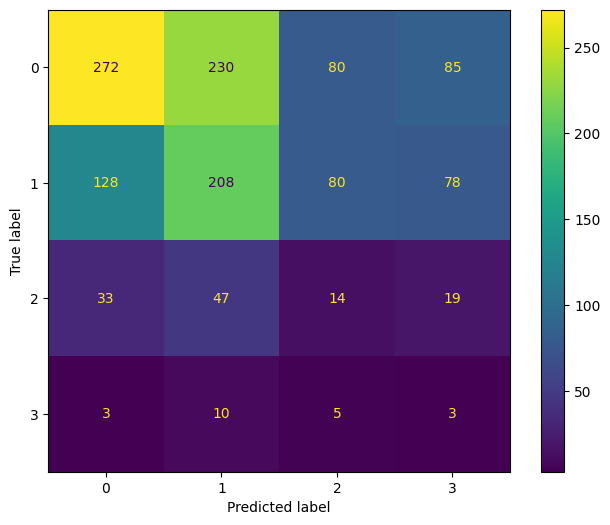

In [37]:
fig, ax = plt.subplots(figsize=(8, 6))


unique_classes = np.unique(np.concatenate([y_test_enc_rf, y_hat_rf]))


display_labels = [label_encoder_rf.classes_[i] for i in unique_classes]

ConfusionMatrixDisplay.from_predictions(
    y_test_enc_rf,
    y_hat_rf,
    display_labels=display_labels,
    ax=ax
)


plt.show()

#### Comparación de Reportes

In [39]:
print("Modelo LSTM:")
print(classification_report(y_test, y_hat_class))

print("Modelo Gradient Boosting:")
print(classification_report(y_test_gb, y_hat_test))

print("Random Forest:")
print(classification_report(y_test_rf, y_hat_rf,))

Modelo LSTM:
              precision    recall  f1-score   support

           0       0.60      0.59      0.59       623
           1       0.39      0.09      0.14       479
           2       0.18      0.59      0.28       111
           3       0.02      0.19      0.04        21

    accuracy                           0.39      1234
   macro avg       0.30      0.36      0.26      1234
weighted avg       0.47      0.39      0.38      1234

Modelo Gradient Boosting:
              precision    recall  f1-score   support

           0       0.61      0.51      0.55       667
           1       0.41      0.32      0.36       494
           2       0.11      0.19      0.14       113
           3       0.05      0.38      0.09        21

    accuracy                           0.41      1295
   macro avg       0.30      0.35      0.29      1295
weighted avg       0.48      0.41      0.44      1295

Random Forest:
              precision    recall  f1-score   support

           0       0.

8. Visualizacion del modelo 
9. Conclusiones y recomendaciones 

### 10. Referencias

1. National Weather Service (NWS). (n.d.). Enhanced Fujita Scale (EF Scale). NOAA.
https://www.weather.gov/oun/efscale
2. Storm Prediction Center (SPC). (n.d.). The Enhanced Fujita Scale (EF Scale). NOAA.
https://www.spc.noaa.gov/faq/tornado/ef-scale.html
3. National Centers for Environmental Information (NCEI). (n.d.). Billion-Dollar Weather and Climate Disasters. NOAA.
https://www.ncei.noaa.gov/access/billions/
4. Federal Emergency Management Agency (FEMA). (n.d.). Tornadoes | Disaster Recovery Resources.
https://www.fema.gov/disaster-recovery-resources/tornadoes

In [ ]:
#frames = []

#for i in range(1, len(df)):
#    frame_data = df.iloc[:i]
#
#    scatter = go.Scattergeo(
#        lon=frame_data['start_longitude'],
#        lat=frame_data['start_latitude'],
#        mode='markers',
#        marker=dict(
#            size=frame_data['magnitude'] * 3,
#            color=frame_data['magnitude'],
#            colorscale='YlOrRd',
#            cmin=0,
#            cmax=df['magnitude'].max(),
#            showscale=False,
#            opacity=0.7
#        ),
#        showlegend=False
#    )
#
#    frames.append(go.Frame(data=[scatter], name=str(i)))
#
#
#fig = go.Figure(
#    data=[frames[0].data[0]],
#    layout=go.Layout(
#        title='Cumulative Tornado Animation',
#        geo=dict(
#            scope='usa',
#            showland=True,
#            landcolor='rgb(217, 217, 217)',
#            subunitcolor='black',
#            showsubunits=True
#        ),
#        updatemenus=[dict(
#            type='buttons',
#            buttons=[dict(label='Play', method='animate', args=[None])]
#        )]
#    ),
#    frames=frames
#)

#fig.show()